## bigram v2 - MLP

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:5], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [3]:
# build the vocab of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = { c:i+1 for i,c in enumerate(chars)}
stoi['.'] =0
itos = { i:c for c,i in stoi.items()}


In [46]:
# build the dataset
block_size = 3 # context length: how many chars do we take to predict the next one
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)



In [48]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [97]:
# build the dataset v2

def build_dataset(words):
  block_size = 3 # context length: how many chars does the model take to predict the next one
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182771, 3]) torch.Size([182771])
torch.Size([22711, 3]) torch.Size([22711])
torch.Size([22664, 3]) torch.Size([22664])


In [49]:
# look up table == embedding layer for input integers
C = torch.rand((27,2))
C.dtype

torch.float32

In [50]:
C[5]

tensor([0.2241, 0.1577])

In [51]:
F.one_hot(torch.tensor(5), 27).float() @ C

tensor([0.2241, 0.1577])

In [52]:
C[X]
C[X].shape

torch.Size([228146, 3, 2])

In [53]:
emb = C[X]  # embeddings of all input sequence


In [54]:
# first hidden layer
W1 = torch.randn((6,100)) # input : 3  char sequence each one has 2 dimensions
b1 = torch.randn(100)

In [55]:
# concatenate emb : [32,3,2] -> [32,6]

# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape  // not a good practice inefficient

# torch.cat(torch.unbind(emb, 1), 1) // better

emb.view(emb.shape[0], -1).shape # -1 inquires torch to guess whats the shape must be


torch.Size([228146, 6])

In [56]:
# first hidden state

h = emb.view(emb.shape[0], -1) @ W1 + b1
h.shape

torch.Size([228146, 100])

In [57]:
# final layer

W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [58]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [59]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [60]:
prob[torch.arange(32), Y].shape # output probabilities of the model for correct chars

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [61]:
# negative log likelihood loss for this batch of 32 input things *sequence of 3 of chars*
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [112]:
# ----------------- better put version -----------------

In [113]:
# X.shape, Y.shape
Xtr.shape, Ytr.shape

(torch.Size([182771, 3]), torch.Size([182771]))

In [121]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]


In [122]:
print('Y shape :', Y.shape)
print('prob shape: ', prob.shape)


print(prob[[0,1], [1,1]])

prob[0][1]

Y shape : torch.Size([228146])
prob shape:  torch.Size([228146, 27])
tensor([9.2627e-17, 1.9059e-16])


tensor(9.2627e-17)

In [123]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [124]:
for p in parameters:
  p.requires_grad = True


In [135]:
lri = []
lossi = []
stepi = []

for i in range(30000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # picks 32 random data rows from X

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2) - embeddings for input - fully linear
  h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100) - hidden layer: linear + tanh
  logits = h @ W2 + b2 # (32, 27)

  # classification
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean()

  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

1.978520154953003


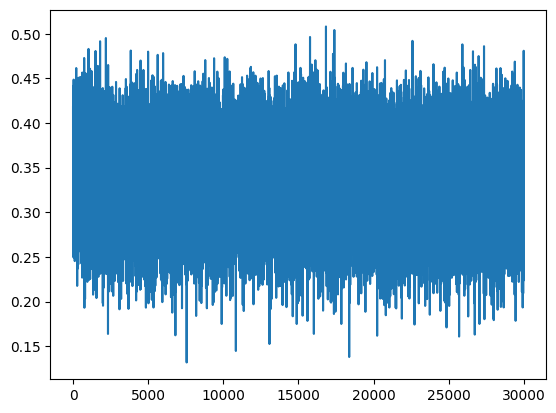

In [136]:
import numpy as np

lossi_log = np.log10(lossi)
plt.plot(stepi,lossi_log)

In [137]:
# cevaluatealculate loss on test data
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1997, grad_fn=<NllLossBackward0>)

In [69]:
torch.randint(0, X.shape[0], (32,)) # picks 32 random data rows from X

tensor([ 69744,  80776, 112267,  20391,  11950, 125566,  31819, 102859,  89381,
         36575,  81515, 176381, 128845,  87152,  33681, 180497,  41609, 224231,
         76773,  83434, 101870,  37483,  44107,  50514, 128335, 219721,  29761,
          5060, 166761,  66773, 159009,  28537])

In [ ]:
# training split, validation/dev split , test split
# 80%, 10%, 10%

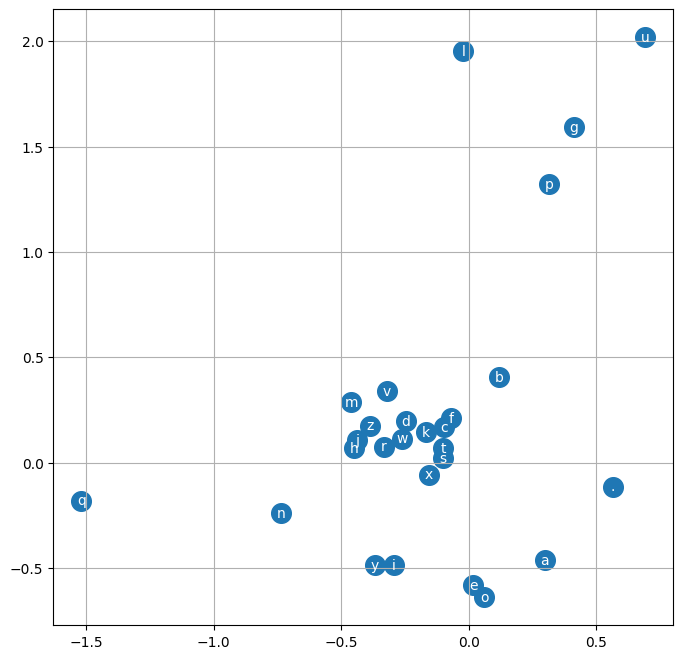

In [120]:
# visualize char embedding space
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [141]:
# sample names from the model
g = torch.Generator().manual_seed(2147485848)

for _ in range(20):
  out = []
  context = [0] * block_size # initialize with (...)
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
        break

  print(''.join(itos[i] for i in out))

emy.
cor.
finny.
edajourn.
sen.
brair.
muck.
avati.
mi.
bra.
malani.
phye.
tam.
zadi.
ily.
wyliah.
abbi.
dey.
ele.
chia.
